# Explaining a Self-Explaining Neural Network
---

<img src="img/SENN.png" alt="SENN Architecture Diagram (Alvarez-Melis \& Jaakkola)]" style="width: 640px;"/>

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Computing the Jacobian with Pytorch Autograd

**How Autograd builds a computation graph?**
* Pytorch autograd engine is based on two major classes: ```Tensor``` and ```Function```
* Using these together, the autograd engine builds a computation graph
* Each ```Tensor``` has a ```.grad_fn``` attribute that records how it was generated
* A user-defined ```Tensor``` (a leaf node on the computation graph) has its ```.grad_fn``` set to ```None```
* A ```Tensor``` generated from an operation like ```+``` or ```*``` has its ```.grad_fn``` set to that ```Function``` operation

**How to compute gradients in the Autograd computation graph?**
* If the ```Tensor``` we want to compute the gradient against is a scalar, we simply call ```.backward()``` on it
* If the ```Tensor``` we want to compute the gradient against is multi-dimensional, we pass a gradient value to the ```.backward()``` method

In [2]:
def jacobian_demo(in_dim, out_dim):
    '''
    A Jacobian Demo:
    Set out_dim = 1 for default behaviour
    Set out_dim > 1 for magic
    '''
    x = torch.ones(in_dim, requires_grad=True)
    w = torch.randn((in_dim, out_dim))
    y = x@w
    print(f"x= {x}")
    print(f"W= {w}")
    print(f"y= {y}")

    if out_dim == 1:
        #y.backward() # equivalent to y.backward(torch.tensor(1.))
        grad_matrix = torch.tensor([1.])
        x_grad = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_matrix,
                                     create_graph=True, only_inputs=True)
    else:
        #y.backward(torch.ones(out_dim))
        grad_matrix = torch.ones(out_dim)
        x_grad = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_matrix,
                                     create_graph=True, only_inputs=True)

    #print(f"dy/dx = {x.grad}")
    print(f"dy/dx = {x_grad}")

In [3]:
jacobian_demo(in_dim=3, out_dim=1)

x= tensor([1., 1., 1.], requires_grad=True)
W= tensor([[-1.1288],
        [ 0.2841],
        [ 0.7726]])
y= tensor([-0.0720], grad_fn=<SqueezeBackward3>)
dy/dx = (tensor([-1.1288,  0.2841,  0.7726]),)


In [4]:
jacobian_demo(in_dim=3, out_dim=2)

x= tensor([1., 1., 1.], requires_grad=True)
W= tensor([[-0.0349,  0.3433],
        [ 1.6677, -1.3803],
        [ 0.9583, -0.1766]])
y= tensor([ 2.5912, -1.2136], grad_fn=<SqueezeBackward3>)
dy/dx = (tensor([0.3084, 0.2875, 0.7817]),)


**PyTorch Autograd behind the scenes**
* Every node in the computation graph recieves the gradient from the node above it
* Autograd computes the product of the Jacobian of the current node with the incoming gradient vector
* So the grad of a node is computed as: $\mathbf{v}^{T} \cdot \mathbf{J}$
* For a scalar node, the incoming gradient vector is just a ```1 x 1``` vector
* The nodes after a scalar node then recieve the Jacobian of the scalar node w.r.t. to a vector as a ```out_dim x 1``` vector

In [5]:
batch = 1
num_features = 3
num_outputs = 2
x = torch.randn(batch, num_features)
print(x.shape)
w = nn.Parameter(torch.randn(num_features, num_outputs))
net = lambda x: x@w

torch.Size([1, 3])


In [6]:
x = x.squeeze()
n = x.size()[0]
x = x.repeat(num_outputs, 1)
x.requires_grad_(True)
print(x.shape)
y = net(x)
print(y.shape)
# step inside this call to see
y.backward(torch.eye(num_outputs))

torch.Size([2, 3])
torch.Size([2, 2])


## Jacobian Function

In [7]:
def jacobian(f, x, out_dim):
    input = x.clone().detach()
    bsize = input.size()[0]
    # (bs, in_dim) --repeated--> (bs, out_dim, in_dim)
    input = input.unsqueeze(1).repeat(1, out_dim, 1)
    input.requires_grad_(True)
    out = f(input).reshape(bsize, out_dim, out_dim)
    # for autograd of non-scalar outputs
    grad_matrix = torch.eye(out_dim).reshape(1,out_dim, out_dim).repeat(bsize, 1, 1)
    out.backward(grad_matrix)
    return input.grad.data

## Test the Jacobian

In [8]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return torch.nn.functional.relu(self.fc1(x))

In [9]:
batch = 2
num_features = 5
num_outputs = 2
x = torch.randn(batch, num_features)
print(x.shape)

torch.Size([2, 5])


In [10]:
f = Net(num_features, num_outputs)

In [11]:
f(x).shape

torch.Size([2, 2])

In [12]:
J = jacobian(f, x, num_outputs)
J, J.shape

(tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.0327, -0.1061,  0.4135, -0.2787, -0.1097]],
 
         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]]),
 torch.Size([2, 2, 5]))

## SENN as Linear Regression

In [13]:
bsize = 10
in_dim = 1
h_dim = in_dim # for the identity conceptizer case
out_dim = 1

In [14]:
def get_sine(bsize):
    x = torch.arange(0, 2*np.pi, 2*np.pi/bsize).unsqueeze(-1)
    y = torch.sin(x)
    return x, y

In [15]:
def get_x2(bsize):
    x = torch.arange(-1, 1, 2/bsize).unsqueeze(-1)
    y = x*x
    return x, y

In [16]:
def get_line(bsize):
    x = torch.arange(-1, 1, 2/bsize).unsqueeze(-1)
    y = 2*x
    return x, y

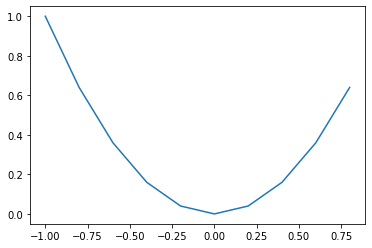

In [17]:
x,y = get_x2(bsize)
plt.plot(x, y)
plt.show()

### Concepts

In [18]:
Conceptualizer = lambda x: x
concepts = Conceptualizer(x)
concepts.shape

torch.Size([10, 1])

### Relevances

In [19]:
w = nn.Parameter(torch.randn(in_dim, out_dim*h_dim))
Parameterizer = lambda x: (x@w) 
relevances = Parameterizer(x)
relevances.shape

torch.Size([10, 1])

### Aggregates

In [20]:
Aggregator = lambda x: (x[0]*x[1]).sum(1).unsqueeze(-1)
aggregates = Aggregator((relevances, concepts))
aggregates.shape

torch.Size([10, 1])

## SENN

### Conceptualizer

In [21]:
class Conceptualizer(nn.Module):
    
    def __init__(self):   super().__init__()
    def forward(self, x): return x

### Parameterizer

In [22]:
class Parameterizer(nn.Module):
    
    def __init__(self, in_dim, h_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn((in_dim, h_dim)))
    
    def forward(self, x):
        return x@self.W

### Aggregator

In [23]:
class Aggregator(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, concepts, relevances):
        return (concepts * relevances)

In [24]:
class SENN(nn.Module):
    
    def __init__(self, conceptualizer, parameterizer, aggregator):
        super().__init__()
        self.conceptualizer = conceptualizer
        self.parameterizer = parameterizer
        self.aggregator = aggregator
    
    def forward(self, x):
        concepts = self.conceptualizer(x)
        relevances = self.parameterizer(x)
        aggregates = self.aggregator(relevances,concepts)
        return aggregates, relevances, concepts

### Robustness Loss

$$\mathcal{L}_\theta := \| \nabla_{x} f(x) - \theta(x)^{T} J_{x}^{h}(x) \|$$

In [25]:
def compute_jacobian(x, fx):
    b = x.shape[0]
    n = x.shape[-1]
    m = fx.shape[-1]
    jacobians = []
    for i in range(m):
        grad_tensor = torch.zeros(b, m)
        grad_tensor[:,i] = 1
        j = torch.autograd.grad(outputs=fx, inputs=x, grad_outputs=grad_tensor,
                                create_graph=True, only_inputs=True)[0]
        jacobians.append(j.view(bsize,-1).unsqueeze(-1)) # b x m x n
    J = torch.cat(jacobians,dim=2)
    return J

### Regression Loss

In [27]:
mse_loss = nn.MSELoss()

### Reconstruction Loss

In [28]:
recon_loss = 0.

## Training

**Loss=** $\mathcal{L}_y (f(x), y) + \lambda \mathcal{L}_\theta (f) + \xi \mathcal{L}_h (x, \hat{x})$

In [41]:
num_epochs = 20
num_features = in_dim
num_classes = out_dim
num_concepts = h_dim
robust_lambda = 0.01

In [42]:
conceptualizer = Conceptualizer()
parameterizer = Parameterizer(num_features, num_concepts)
aggregator = Aggregator()
senn = SENN(conceptualizer, parameterizer, aggregator)

In [43]:
opt = optim.SGD(senn.parameters(), lr=0.3)

In [44]:
for epoch in range(num_epochs):
    # enable tracing to compute jacobian for robustness loss
    x.requires_grad_(True)
    aggregates, relevances, concepts = senn(x)

    J_yx = compute_jacobian(x, aggregates)
    J_hx = compute_jacobian(x, concepts)
    relevances = relevances.reshape(-1,num_classes,num_concepts)
    robustness_loss = (J_yx - torch.bmm(relevances, J_hx)).norm(p='fro')    
    
    regression_loss = mse_loss(aggregates, y) 
    loss = regression_loss + robust_lambda*robustness_loss + recon_loss
    
    print(f"EPOCH#{epoch+1}\t"
          f"Loss:{loss:.3f} "
          f"Regression:{regression_loss:.3f} "
          f"Robustness: {robustness_loss:.3f}")
    loss.backward()
    opt.step()
    opt.zero_grad()

EPOCH#1	Loss:0.273 Regression:0.271 Robustness: 0.234
EPOCH#2	Loss:0.204 Regression:0.204 Robustness: 0.042
EPOCH#3	Loss:0.160 Regression:0.157 Robustness: 0.262
EPOCH#4	Loss:0.126 Regression:0.121 Robustness: 0.454
EPOCH#5	Loss:0.100 Regression:0.094 Robustness: 0.622
EPOCH#6	Loss:0.080 Regression:0.073 Robustness: 0.768
EPOCH#7	Loss:0.065 Regression:0.056 Robustness: 0.896
EPOCH#8	Loss:0.054 Regression:0.044 Robustness: 1.007
EPOCH#9	Loss:0.045 Regression:0.034 Robustness: 1.104
EPOCH#10	Loss:0.039 Regression:0.027 Robustness: 1.188
EPOCH#11	Loss:0.034 Regression:0.021 Robustness: 1.262
EPOCH#12	Loss:0.030 Regression:0.017 Robustness: 1.326
EPOCH#13	Loss:0.027 Regression:0.013 Robustness: 1.382
EPOCH#14	Loss:0.025 Regression:0.011 Robustness: 1.431
EPOCH#15	Loss:0.023 Regression:0.009 Robustness: 1.474
EPOCH#16	Loss:0.022 Regression:0.007 Robustness: 1.511
EPOCH#17	Loss:0.021 Regression:0.006 Robustness: 1.543
EPOCH#18	Loss:0.020 Regression:0.005 Robustness: 1.572
EPOCH#19	Loss:0.020

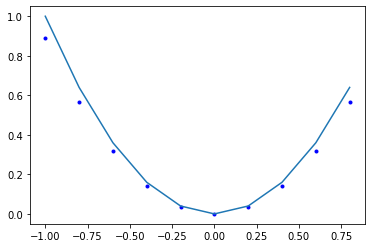

In [45]:
with torch.no_grad():
    aggregates, relevances, concepts = senn(x)
    plt.plot(x, aggregates, "b.")
    plt.plot(x, y)

In [46]:
senn.parameterizer.W.item()

0.8875086307525635